# Reduced Gravity

## Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

GPU Ocean-modules:

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization, Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [3]:
%cuda_context_handler gpu_ctx

Plot utils

In [4]:
from IPython.display import clear_output
from matplotlib import animation, rc
plt.rcParams["animation.html"] = "jshtml"
from gpuocean.utils import PlotHelper
from gpuocean.utils.NetCDFInitialization import depth_integration

def plotSolution(fig, 
                 eta, hu, hv, h, dx, dy, 
                 t, comment,
                 h_min=-1.5, h_max=1.5, 
                 uv_min=-0.3, uv_max=0.3,
                 calc_uv = False, 
                 add_extra=False,
                 reduced_gravity_interface=None,
                 ax=None, sp=None):


    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    ny, nx = eta.shape
    domain_extent = [0, nx*dx, 0, ny*dy]
    
    x_plots = 3
    y_plots = 1
    if (add_extra == True):
        x_plots=3
        y_plots=2
    
    V_max = 3 * (uv_max-uv_min) / np.max(h)
    R_min = -V_max/2000
    R_max = V_max/2000
   
    huv_label = ["hu","hv"]
    if calc_uv:
        """plotting actually u and v"""
        if reduced_gravity_interface is None or reduced_gravity_interface == 0.0:
            hu = hu/(h+eta)
            hv = hv/(h+eta)
        else:
            hu = hu/(reduced_gravity_interface+eta)
            hv = hv/(reduced_gravity_interface+eta)
        uv_min = -0.3
        uv_max = +0.3
        huv_label = ["u","v"]

    if (ax is None):
        ax = [None]*x_plots*y_plots
        sp = [None]*x_plots*y_plots
        
        ax[0] = plt.subplot(y_plots, x_plots, 1)
        sp[0] = ax[0].imshow(eta, interpolation="none", origin='lower', 
                             cmap=plt.cm.coolwarm, 
                             vmin=h_min, vmax=h_max, 
                             extent=domain_extent)
        plt.colorbar(sp[0], shrink=0.9)
        plt.axis('image')
        plt.title("$\eta{}$")
        
  

        ax[1] = plt.subplot(y_plots, x_plots, 2)
        sp[1] = ax[1].imshow(hu, interpolation="none", origin='lower', 
                            cmap=plt.cm.coolwarm, 
                            vmin=uv_min, vmax=uv_max, 
                            extent=domain_extent)
        plt.colorbar(sp[1], shrink=0.9)
        plt.axis('image')
        plt.title("$"+huv_label[0]+"$")



        ax[2] = plt.subplot(y_plots, x_plots, 3)
        sp[2] = ax[2].imshow(hv, interpolation="none", origin='lower', 
                             cmap=plt.cm.coolwarm, 
                             vmin=uv_min, vmax=uv_max, 
                             extent=domain_extent)
        plt.colorbar(sp[2], shrink=0.9)
        plt.axis('image')
        plt.title("$"+huv_label[1]+"$")
            
    else:        
        #Update plots
        fig.sca(ax[0])
        sp[0].set_data(eta)
        
        fig.sca(ax[1])
        sp[1].set_data(hu)
        
        fig.sca(ax[2])
        sp[2].set_data(hv)
        
        if (add_extra == True):
            V = PlotHelper.genVelocity(h, hu, hv)
            fig.sca(ax[3])
            sp[3].set_data(V)

            R = PlotHelper.genColors(h, hu/dx, hv/dy, plt.cm.seismic, R_min, R_max)
            fig.sca(ax[4])
            sp[4].set_data(R)
    
    return ax, sp

def ncAnimation(filename, movie_frames=None, create_movie=True, fig=None, x0=0, x1=-1, y0=0, y1=-1, reduced_gravity_interface=None, **kwargs):
    #Create figure and plot initial conditions
    if fig is None:
        fig = plt.figure(figsize=(14, 4))

    try:
        ncfile = Dataset(filename)
        try:
            x = ncfile.variables['x'][:]
        except:
            x = ncfile.variables['X'][x0:x1]
        try:
            y = ncfile.variables['y'][:]
        except:
            y = ncfile.variables['Y'][y0:y1]
        t = ncfile.variables['time'][:]

        try:
            H_m = ncfile.variables['Hm'][:,:]
        except:
            H_m = ncfile.variables['h'][y0:y1,x0:x1]
        try:
            eta = ncfile.variables['eta'][:,:,:]
        except:
            eta = ncfile.variables['zeta'][:,y0:y1,x0:x1]
        try:
            hu = ncfile.variables['hu'][:,:,:]
            calc_uv = True
        except:
            if reduced_gravity_interface is None:
                hu = ncfile.variables['ubar'][:,y0:y1,x0:x1]
                calc_uv = False
            else:
                if reduced_gravity_interface > 0.0:
                    hu = np.ma.zeros(eta.shape)
                    for t_idx in range(len(t)):
                        hu[t_idx] = depth_integration(ncfile, reduced_gravity_interface, x0, x1, y0, y1, "u", timestep_index=t_idx)
                    calc_uv = True
                else:
                    hu = ncfile.variables['u'][:,0,y0:y1,x0:x1]
                    calc_uv = False
        try:
            hv = ncfile.variables['hv'][:,:,:]
        except:
            if reduced_gravity_interface is None:
                hv = ncfile.variables['vbar'][:,y0:y1,x0:x1]
            else:
                if reduced_gravity_interface > 0.0:
                    hv = np.ma.zeros(eta.shape)
                    for t_idx in range(len(t)):
                        hv[t_idx] = depth_integration(ncfile, reduced_gravity_interface, x0, x1, y0, y1, "v", timestep_index=t_idx)
                else:
                    hv = ncfile.variables['v'][:,0,y0:y1,x0:x1]
                    
    except Exception as e:
        raise e
    finally:
        ncfile.close()


    if movie_frames is None:
        movie_frames = len(t)

    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    progress = Common.ProgressPrinter(5)

    if (create_movie):
        ax, sp = plotSolution(fig, 
                              eta[0],
                              hu[0],
                              hv[0],
                              H_m+eta[0],
                              dx, dy, 
                              t[0], filename,
                              calc_uv=calc_uv,
                              reduced_gravity_interface=reduced_gravity_interface,
                              **kwargs)
    else:
        ax, sp = plotSolution(fig, 
                              eta[-1],
                              hu[-1],
                              hv[-1],
                              H_m+eta[-1],
                              dx, dy, 
                              t[-1], filename,
                              **kwargs)
        return

    #Helper function which simulates and plots the solution    
    def animate(i):
        t_now = t[0] + (i / (movie_frames-1)) * (t[-1] - t[0]) 

        k = np.searchsorted(t, t_now)
        if (k >= eta.shape[0]):
            k = eta.shape[0] - 1
        j = max(0, k-1)
        if (j == k):
            k += 1
        s = (t_now - t[j]) / (t[k] - t[j])

        plotSolution(fig, 
                        (1-s)*eta[j] + s*eta[k], 
                        (1-s)*hu[j]  + s*hu[k], 
                        (1-s)*hv[j]  + s*hv[k], 
                        H_m+(1-s)*eta[j] + s*eta[k], 
                        dx, dy, 
                        t_now, filename,
                        calc_uv=calc_uv,
                        reduced_gravity_interface=reduced_gravity_interface,
                        **kwargs, ax=ax, sp=sp)

        clear_output(wait = True)
        #print(progress.getPrintString(i / (movie_frames-1)))

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(movie_frames), interval=250)
    plt.close(fig)
    
    return anim


## Selecting Area

As initial and boundary conditions to the simulation, we use data from the Norkyst800 model:

In [5]:
source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m/NorKyst-800m_ZDEPTHS_avg.an.2019071600.nc'

In [42]:
casename = 'skagerak'

from importlib import reload
from gpuocean.utils import NetCDFInitialization
reload(NetCDFInitialization)
case_info = NetCDFInitialization.getCaseLocation(casename)
case_info.pop("name")

'skagerak'

## Simulating

In [43]:
from importlib import reload 
reload(NetCDFInitialization)
data_args = NetCDFInitialization.getInitialConditions(source_url,case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"], download_data=False)
data_args.keys()

dict_keys(['sponge_cells', 'NX', 'NY', 'nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind_stress', 'wind', 'note', 't0', 'timesteps'])

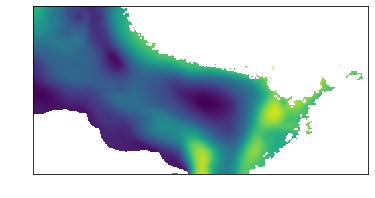

In [44]:
plt.imshow(data_args["eta0"], origin="lower")

In [46]:
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "write_netcdf":True
     }

sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))

for hour in range(2*24):
    sim.step(3600.0)

swe_anim = ncAnimation(sim.sim_writer.output_file_name)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [47]:
swe_anim

# Reduced Gravity simulation 

For now, we initialise the simulation with
- bathymetyry cut at `reduced_gravity_interface` in metre (has to be a z-level in NorKyst)
- initial states that are integrated from `reduced_gravity_interface` up to 0 from NorKyst (ignoring `eta`)
- boundary forcing from NorKyst as initial conditions
- reduced gravitation `g=0.1`

The equations (compared to the one-layer model) change
- no forcing from bathymetry! (if bathymetry lower than interface we remain bathymetry forcing)

Next, showing the direct results from the model (no superposition as Kai suggested in the previous meeting)

In [48]:
from importlib import reload
reload(NetCDFInitialization)
reduced_data_args = NetCDFInitialization.getInitialConditions(source_url,case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"], download_data=False, reduced_gravity_interface=25)
reduced_data_args.keys()

Cut the bathymetry: no reconstruction!
Depth integration with trapeziodal rule, ignoring eta
Reduce gravity (fixed value used)
Depth integration with trapeziodal rule, ignoring eta


dict_keys(['sponge_cells', 'NX', 'NY', 'nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind_stress', 'wind', 'note', 't0', 'timesteps'])

In [53]:
reduced_sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "write_netcdf":True
    }

reduced_sim = CDKLM16.CDKLM16(**reduced_sim_args, **NetCDFInitialization.removeMetadata(reduced_data_args))

for hour in range(2*24):
    reduced_sim.step(3600.0)

reduced_swe_anim = ncAnimation(reduced_sim.sim_writer.output_file_name)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/netcdf_2022_07_06/CDKLM16_2022_07_06-10_20_21.nc ...


In [54]:
reduced_swe_anim